In [2]:
import random  # Functions related to random number generation
import numpy as np  # Numerical library for mathematical operations
import os  # Functions related to the operating system
import pandas as pd  # Library for data manipulation and analysis of tabular data
import time  # To calculate the runtime
import seaborn as sns
import calendar

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, concatenate
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, MaxPooling1D, Conv1D, TimeDistributed, Flatten, ConvLSTM2D, RepeatVector, TimeDistributed
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from prophet.plot import plot_plotly, add_changepoints_to_plot, plot_components_plotly, plot_forecast_component, plot_yearly


import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")
                        
#We take the data from the file that we have in the same folder 
df = pd.read_csv("GlobalLandTemperaturesByCity.csv", parse_dates=['dt'], index_col='dt')
df

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
...,...,...,...,...,...,...
2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E
2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E
2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E


In [8]:
# Lista de países mediterráneos
mediterranean_countries = [
    'Spain', 'France', 'Monaco', 'Italy', 'Slovenia', 'Croatia', 
    'Bosnia and Herzegovina', 'Montenegro', 'Albania', 'Greece', 
    'Turkey', 'Cyprus', 'Syria', 'Lebanon', 'Israel', 'Egypt', 
    'Libya', 'Tunisia', 'Algeria', 'Morocco'
]

# Filtrar el DataFrame para incluir solo los países mediterráneos
df_mediterranean = df[df['Country'].isin(mediterranean_countries)]

# Mostrar los primeros registros del DataFrame filtrado
df_mediterranean.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-01,10.013,2.291,Çorlu,Turkey,40.99N,27.69E
1743-12-01,NaN,NaN,Çorlu,Turkey,40.99N,27.69E
1744-01-01,NaN,NaN,Çorlu,Turkey,40.99N,27.69E
1744-02-01,NaN,NaN,Çorlu,Turkey,40.99N,27.69E
1744-03-01,NaN,NaN,Çorlu,Turkey,40.99N,27.69E


In [6]:
n_rows = df_mediterranean.shape[0]
print("Number of rows", n_rows)

Number of rows 800128


In [9]:
print(df_mediterranean.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800128 entries, 1743-11-01 to 2013-09-01
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   AverageTemperature             783853 non-null  float64
 1   AverageTemperatureUncertainty  783853 non-null  float64
 2   City                           800128 non-null  object 
 3   Country                        800128 non-null  object 
 4   Latitude                       800128 non-null  object 
 5   Longitude                      800128 non-null  object 
dtypes: float64(2), object(4)
memory usage: 42.7+ MB
None


In [10]:
# Descriptive stadistics
print(df_mediterranean.describe())

       AverageTemperature  AverageTemperatureUncertainty
count       783853.000000                  783853.000000
mean            14.386479                       1.388361
std              7.450161                       1.470289
min            -15.353000                       0.052000
25%              8.970000                       0.389000
50%             14.564000                       0.773000
75%             20.176000                       1.942000
max             39.651000                      13.768000


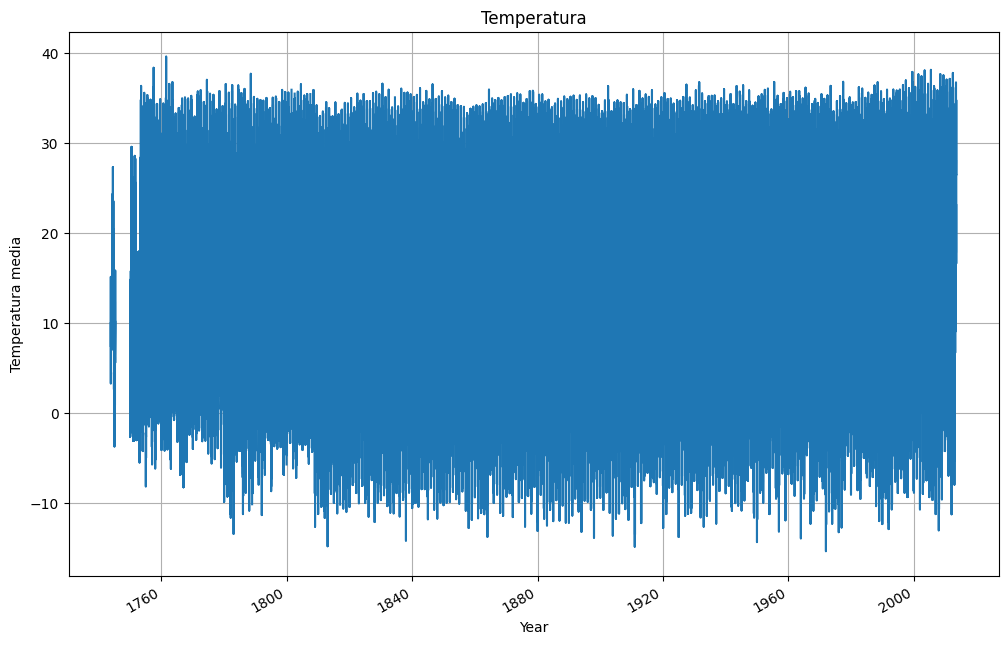

In [15]:

ax = df_mediterranean['AverageTemperature'].plot(figsize=(12, 8))
ax.set(ylabel='Temperatura media', xlabel='Year', title='Temperatura');
ax.grid()

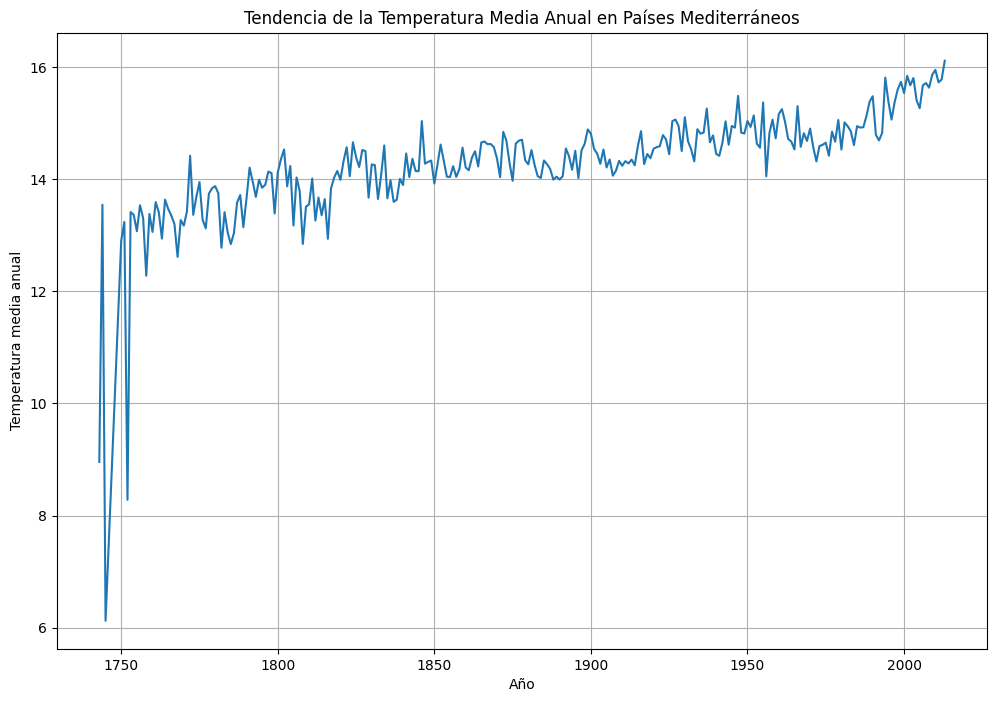

In [18]:
# Crear una columna "Year" a partir del índice temporal
df_mediterranean['Year'] = df_mediterranean.index.year

# Agrupar por año y calcular la temperatura media anual
df_annual = df_mediterranean.groupby('Year')['AverageTemperature'].mean().dropna()

# Graficar la temperatura media anual
ax = df_annual.plot(figsize=(12, 8))
ax.set(ylabel='Temperatura media anual', xlabel='Año', title='Tendencia de la Temperatura Media Anual en Países Mediterráneos')
ax.grid()
plt.show()


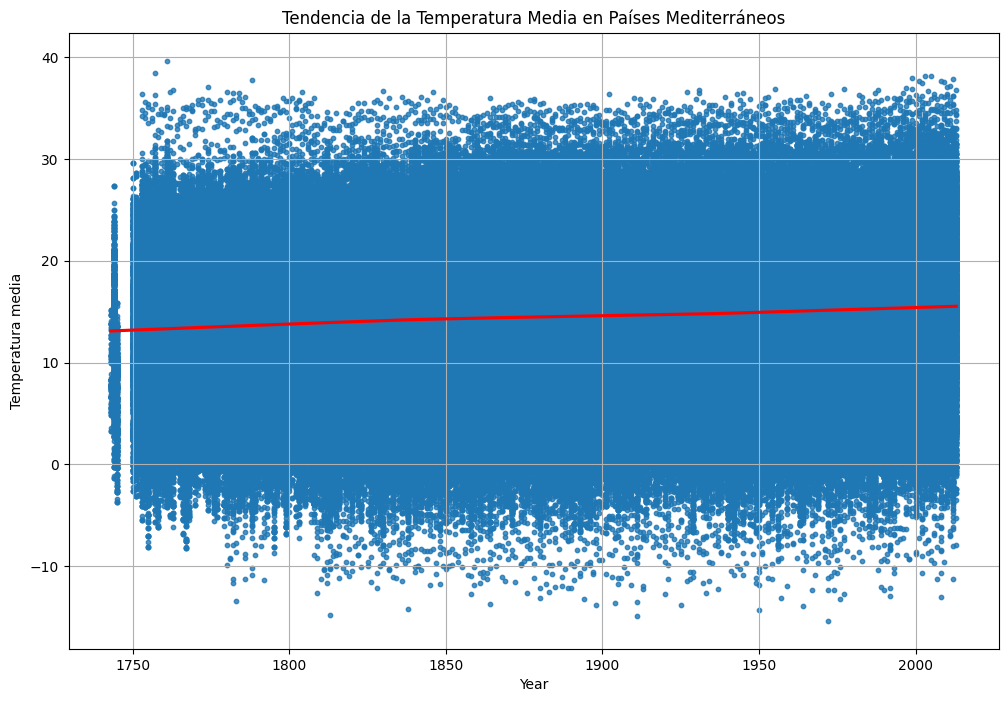

In [17]:
# Crear el gráfico de temperatura media con una línea de tendencia
plt.figure(figsize=(12, 8))
sns.regplot(x=df_mediterranean.index.year, y=df_mediterranean['AverageTemperature'], 
            scatter_kws={'s': 10}, line_kws={'color': 'red'}, lowess=True)
plt.ylabel('Temperatura media')
plt.xlabel('Year')
plt.title('Tendencia de la Temperatura Media en Países Mediterráneos')
plt.grid()
plt.show()